In [84]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## Data loading

In [41]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/superstore_sales_dataset.csv')
df.shape

(9800, 18)

In [42]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [43]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

## Initial Data Analysis

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [45]:
df.isnull().sum().sum(), df.isna().sum().sum()

(11, 11)

In [46]:
df.isnull().sum()[df.isnull().sum() > 0]

Postal Code    11
dtype: int64

In [47]:
df.duplicated().sum()

0

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9800.0,4900.500000,2829.160653,1.000,2450.750,4900.50,7350.250,9800.00
Postal Code,9789.0,55273.322403,32041.223413,1040.000,23223.000,58103.00,90008.000,99301.00
Sales,9800.0,230.769059,626.651875,0.444,17.248,54.49,210.605,22638.48


In [49]:
df.describe(include='object')

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800
unique,4922,1230,1326,4,793,793,3,1,529,49,4,1861,3,17,1849
top,CA-2018-100111,05/09/2017,26/09/2018,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,38,34,5859,35,35,5101,9800,891,1946,3140,19,5909,1492,47


Summary:
- dataset has 9800 samples and 18 features
- Postal Code is categorical value and has 11 missed values
- Sales contains outpliers (max=22638.48 and 75%=210.605)
- Customer ID has only 793 unique cumstomers
- Country has only one unique value
- Product ID contains both Category and Sub-Category
- Collision: unique Product ID != unique Porduct Name



## Exploratory Data Analysis

Deleting unnecessary columns

In [50]:
df.drop(['Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Country', 'Region', 'Product ID'], axis=1, inplace=True)
df.shape

(9800, 11)

Dealing with missed data

In [51]:
df[df['Postal Code'].isnull()]

,Order Date,Ship Date,Ship Mode,Segment,City,State,Postal Code,Category,Sub-Category,Product Name,Sales
2234,05/12/2018,10/12/2018,Standard Class,Corporate,Burlington,Vermont,NaN,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,07/11/2016,09/11/2016,Second Class,Consumer,Burlington,Vermont,NaN,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,06/04/2017,10/04/2017,Standard Class,Home Office,Burlington,Vermont,NaN,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,23/01/2017,27/01/2017,Standard Class,Corporate,Burlington,Vermont,NaN,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,23/01/2017,27/01/2017,Standard Class,Corporate,Burlington,Vermont,NaN,Office Supplies,Art,4009 Highlighters,8.04
9148,23/01/2017,27/01/2017,Standard Class,Corporate,Burlington,Vermont,NaN,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,19/01/2018,23/01/2018,Standard Class,Consumer,Burlington,Vermont,NaN,Office Supplies,Paper,Xerox 191,79.92
9387,19/01/2018,23/01/2018,Standard Class,Consumer,Burlington,Vermont,NaN,Office Supplies,Paper,Xerox 1881,12.28
9388,19/01/2018,23/01/2018,Standard Class,Consumer,Burlington,Vermont,NaN,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,19/01/2018,23/01/2018,Standard Class,Consumer,Burlington,Vermont,NaN,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


Filling a Postal Code column with 05401 in Burlingtom, Vermont

In [52]:
df['Postal Code'].fillna(5401, inplace=True)

Converting Postal Code to categorical column

In [53]:
df['Postal Code'] = df['Postal Code'].astype('object')

Converting Order Date and Ship Date columns to datetime format

In [54]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

<ipython-input-54-9d9e7d6e3ad3>:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-54-9d9e7d6e3ad3>:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



Defining numerical and categorical columns

In [55]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=[object, np.datetime64]).columns.tolist()

Look for a distribution of numerical column

<Axes: >

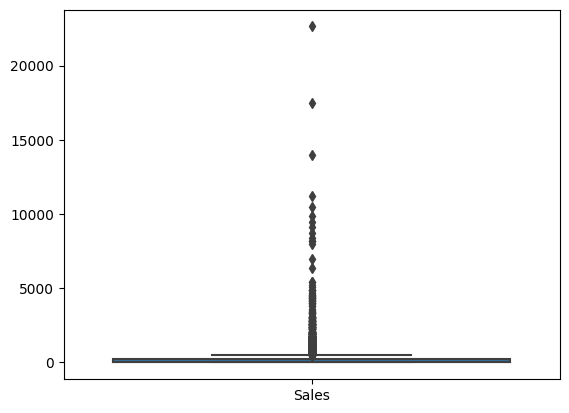

In [56]:
sns.boxplot(df[numerical_columns])

Removing outliers

In [57]:
df = df[~(df['Sales'] > 1000)]
df.shape

(9338, 11)

Look for a distribution of categorical columns

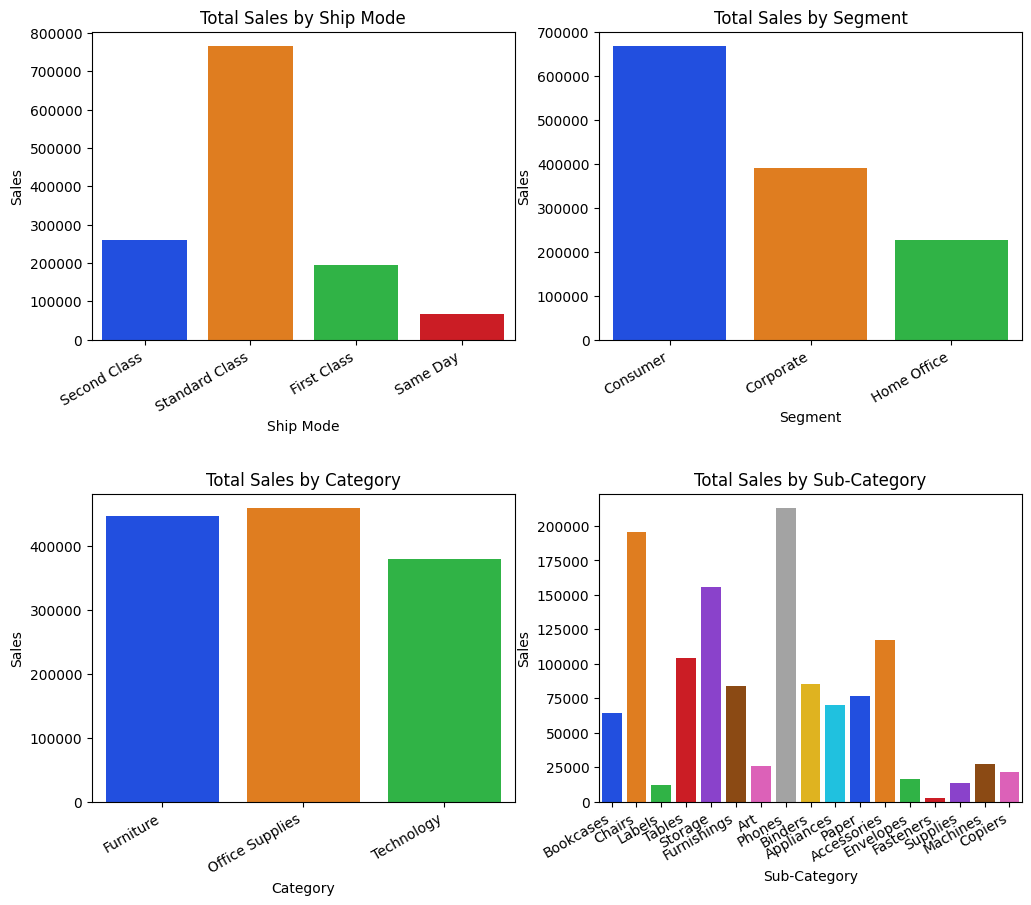

In [58]:
columns = ['Ship Mode', 'Segment', 'Category', 'Sub-Category']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=column, y='Sales', data=df, estimator=np.sum, errorbar=None, palette='bright', ax=ax)
    ax.set_title(f'Total Sales by {column}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

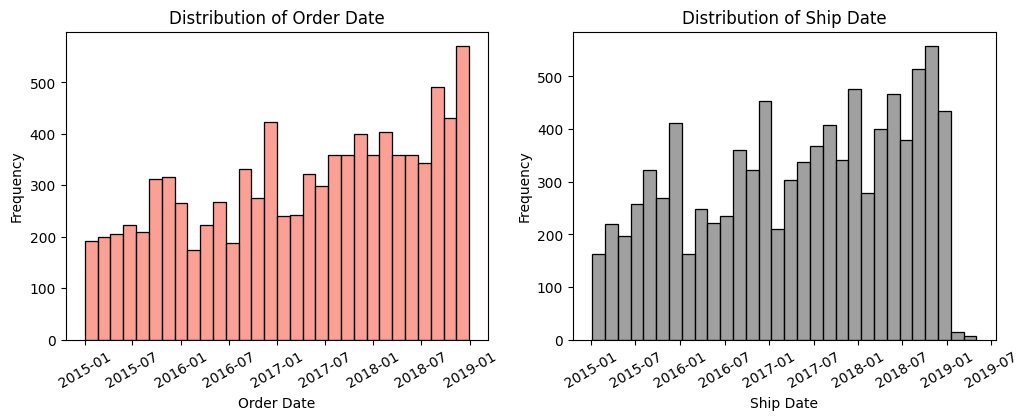

In [59]:
columns = ['Order Date', 'Ship Date']
colors = ['salmon', 'gray']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, column in enumerate(columns):
    sns.histplot(df[column], bins=30, kde=False, color=colors[i], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=30)


In [60]:
df.columns

Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'City', 'State',
       'Postal Code', 'Category', 'Sub-Category', 'Product Name', 'Sales'],
      dtype='object')

## Visualization

In [61]:
all_states = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
    "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

In [82]:
sales_by_state = df.groupby('State')['Sales'].sum().reset_index()
sales_by_state['abbreviation'] = sales_by_state['State'].map(all_states)

fig = go.Figure(data=go.Choropleth(
    locations=sales_by_state['abbreviation'],
    locationmode='USA-states',
    z=sales_by_state['Sales'],
    hoverinfo='location+z',
    showscale=True
))
fig.update_layout(
    geo_scope='usa',
    title='Total Sales by State',
    width=800
)

fig.show()

In [63]:
top_cities = df.groupby("City").sum().sort_values("Sales", ascending=False).head(20)
top_cities = top_cities[['Sales']].round(2)
top_cities.reset_index(inplace=True)

fig = px.bar(top_cities, x='City', y='Sales', title="Sales by 20 Cities", width=800)
fig.show()

<ipython-input-63-74e7821924e1>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [64]:
sales_by_category = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
fig = px.sunburst(
    sales_by_category,
    path=['Category', 'Sub-Category'],
    values='Sales',
    title='Sales by Category and Sub-Category',
    width=800,
    height=600,
)

fig.show()

In [65]:
columns = ['Ship Mode', 'Segment']

fig = make_subplots(rows=1, cols=2, subplot_titles=columns, specs=[[{'type':'pie'}, {'type':'pie'}]])

fig.add_trace(
    go.Pie(
        labels=df['Ship Mode'].value_counts().index,
        values=df['Ship Mode'].value_counts().values,
    ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(
        labels=df['Segment'].value_counts().index,
        values=df['Segment'].value_counts().values,
    ),
    row=1, col=2
)

fig.update_layout(
    title_text='Sales by Ship Mode and Segment',
    width=800
)

fig.show()

In [66]:
categ_ship_mode = df.groupby(['Category', 'Ship Mode', 'Sub-Category'])['Sales'].sum().reset_index()

fig = px.treemap(
    categ_ship_mode,
    path=['Category', 'Ship Mode', 'Sub-Category'],
    values='Sales',
)

fig.update_layout(title='Tree of Sales distibution by Category, Sub-Category and Ship Mode', width=800)
fig.show()

In [67]:
df.corr()

<ipython-input-67-2f6f6606aa2c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Sales
Sales,1.0


## Feature engineering

Converting dates to int

In [68]:
df['Order Date'] = pd.to_datetime(df['Order Date']).astype(int) // 10**9
df['Ship Date'] = pd.to_datetime(df['Ship Date']).astype(int) // 10**9

Removing dependent columns

In [69]:
df.drop(['Postal Code', 'Category'], axis=1, inplace=True)

Converting categorical columns to OneHot

In [70]:
train_df = pd.get_dummies(df)

Defining X and y

In [71]:
X = train_df.drop('Sales', axis=1)
y = train_df['Sales']

Splitting a data into train and test sets

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

In [73]:
xgb_reg = XGBRegressor()

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [74]:
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

21390.947027221027

In [80]:
feature_importances = xgb_reg.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

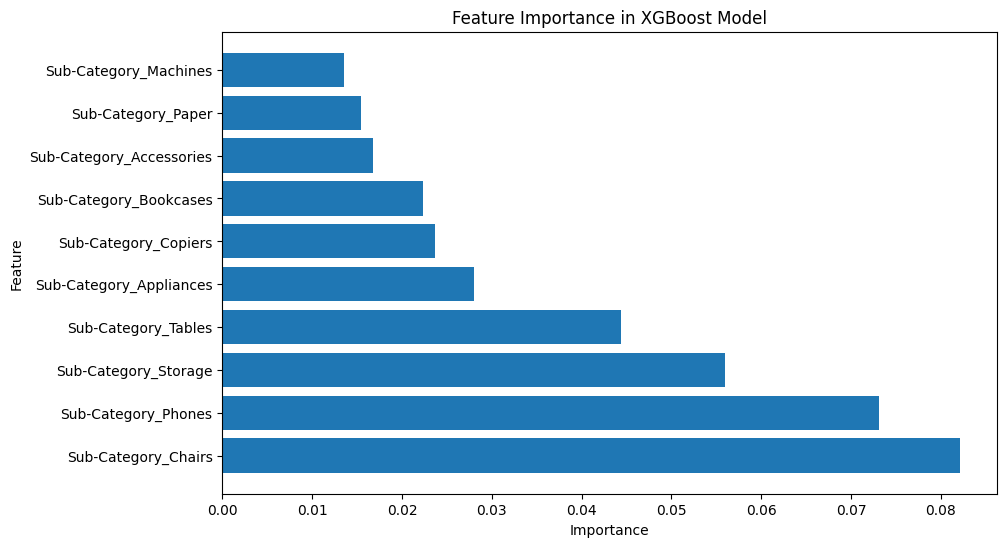

In [81]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()

In [75]:
xgb_reg_tuned = XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_reg_tuned.fit(X_train, y_train)
y_pred_tuned = xgb_reg_tuned.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mse_tuned

Tuned Mean Squared Error: 18864.36148069448


Using GridSearchCV

In [85]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [86]:
xgb_reg = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

In [87]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [90]:
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 200,
 'subsample': 0.8}

In [89]:
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

20597.439254028377